## Metrics for classification

In here we will be evaluating the performance of binary classifiers by computing a confusion matrix and generating a classification report.

We will work with the PIMA Indians dataset obtained from the UCI Machine Learning Repository. 
The goal is to predict whether or not a given female patient will contract diabetes based on features such as BMI, age, and number of pregnancies. Therefore, it is a binary classification problem. A target value of 0 indicates that the patient does not have diabetes, while a value of 1 indicates that the patient does have diabetes. As in Chapters 1 and 2, the dataset has been preprocessed to deal with missing values.


In [1]:
# Import the necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("diabetes.csv")
X = df.iloc[:,1:-1].values
y = df.iloc[:,-1].values


In [2]:


# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[170  36]
 [ 41  61]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       206
           1       0.63      0.60      0.61       102

    accuracy                           0.75       308
   macro avg       0.72      0.71      0.71       308
weighted avg       0.75      0.75      0.75       308



## Plotting an ROC curve



Most classifiers in scikit-learn have a .predict_proba() method which returns the probability of a given sample being in a particular class. 

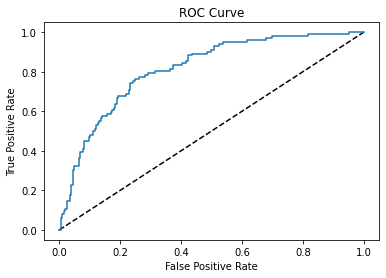

In [3]:
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Precision-recall Curve

When looking at your ROC curve, you may have noticed that the y-axis (True positive rate) is also known as recall. Indeed, in addition to the ROC curve, there are other ways to visually evaluate model performance. One such way is the precision-recall curve, which is generated by plotting the precision and recall for different thresholds. As a reminder, precision and recall are defined as:

<img src="image1.png">

Average precision-recall score: 0.65


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.65')

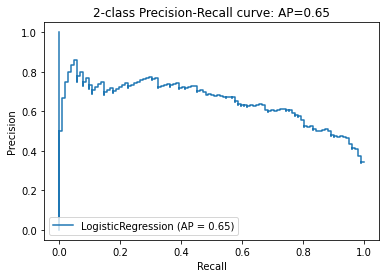

In [4]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

#print("Precision",precision)
#print("Recall",recall)
y_score = logreg.decision_function(X_test)


average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


# Plot Precision-Recall curve
disp = plot_precision_recall_curve(logreg, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## AUC computation

Say you have a binary classifier that in fact is just randomly making guesses. It would be correct approximately 50% of the time, and the resulting ROC curve would be a diagonal line in which the True Positive Rate and False Positive Rate are always equal. The Area under this ROC curve would be 0.5. This is one way in which the AUC, is an informative metric to evaluate a model.
If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!

In [5]:
# Import necessary modules
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))


AUC: 0.8142014087188273
AUC scores computed using 5-fold cross-validation: [0.81759259 0.79055556 0.82166667 0.86867925 0.83377358]


## Hyperparameter tuning with GridSearchCV

Logistic regression also has a regularization parameter: C.
    
C controls the inverse of the regularization strength, and this is what you will tune in this exercise. A large C can lead to an overfit model, while a small C can lead to an underfit model.

We will use GridSearchCV and logistic regression to find the optimal C in the given hyperparameter space.

In [6]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 0.7760801290213054


## Hyperparameter tuning with RandomizedSearchCV

GridSearchCV can be computationally expensive, especially if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. A solution to this is to use RandomizedSearchCV, in which not all hyperparameter values are tried out. Instead, a fixed number of hyperparameter settings is sampled from specified probability distributions. 

In [7]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 7}
Best score is 0.7435107376283847


### Hold-out set in practice I: Classification

Why a hold-out set?
Using ALL data for cross validation is not ideal.
How well can the model perform on never before seen data?
-Split the data into training and hold-out set at the beginning
-Perform grid search cross-validation on training set
-Chose best hyperparameters and evaluate on hold-out set

We will evaluate a model with tuned hyperparameters on a hold-out set.

In addition to C, logistic regression has a 'penalty' hyperparameter which specifies whether to use 'l1' or 'l2' regularization. We will create a hold-out set, tune the 'C' and 'penalty' hyperparameters of a logistic regression classifier using GridSearchCV on the training set.

In [8]:
# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 0.006105402296585327, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7652173913043476


### Hold-out set in practice II: Regression

Remember lasso and ridge regression from the previous chapter? Lasso used the L1 penalty to regularize, while ridge used the L2 penalty. There is another type of regularized regression known as the elastic net. In elastic net regularization, the penalty term is a linear combination of the L1 and L2 penalties:

                                    a∗L1+b∗L2

In scikit-learn, this term is represented by the 'l1_ratio' parameter: An 'l1_ratio' of 1 corresponds to an L1 penalty, and anything lower is a combination of L1 and L2.

Here we will use GridSearchCV to tune the 'l1_ratio' of an elastic net model trained on the Gapminder data. 
We will use a hold-out set to evaluate the model's performance.

In [9]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.034482758620689655}
Tuned ElasticNet R squared: 0.22976388546503113
Tuned ElasticNet MSE: 0.17060424648558745
